# Mapping NY State: Population Density with Datashader

In this notebook, we'll use the same clean US Census population and geographic data we mapped in the last notebook, but instead of uding Kepler GL, we'll map population density using Datashader. Let's see if Datashader can help speed up our load time.

#### *Up close: data cleaning and mapping*

The notebooks below provide a detailed look at the other stages of cleaning and mapping data for this project. The final steps of creating a SQL database of indoor farms in New York City and then mapping them will follow shortly.

* [Introduction: The State of Indoor Farming in the US](00_IndoorAgriculture_start.ipynb) 
* [Data Cleanup: US Census population data](01_DataCleanup_Population.ipynb) 
* [Data Cleanup: GEOID tables](02_DataCleanup_GEOIDs.ipynb)
* [Data Cleanup: Geographic data](03_DataCleanup_GIS.ipynb)
<!-- * [Mapping NY State: Population Density](http://localhost:8888/lab/tree/notebooks/04_Mapping_Population.ipynb) -->
* SQL Database Creation: Indoor Farms - *coming soon...*
* Mapping NY State: Indoor Farms - *coming soon...*

#### *Some helper code for managing file paths*
We'll use the code below throughout this project to make it easier to refer to the folders where our various data files are stored.

In [1]:
# os and pathlib modules used to make it easier to refer to project folders 

import os, pathlib
base_dir = pathlib.Path(os.getcwd()).parent
data_archive_dir = os.path.join(base_dir, "data_archive")
clean_data_dir = os.path.join(data_archive_dir, "clean")
data_dir = os.path.join(base_dir, "data")
shapes_dir = os.path.join(data_dir,"shapes")
json_dir = os.path.join(data_dir,"geojson")
util_dir = os.path.join(data_dir,"util")

#### *Imports*

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
import spatialpandas as sp
from shapely import wkt

In [4]:
# commenting this out for now because we're still working with CSV files
# we'd rather work with parquet files, but first need to fix the issue with it mangling geometry data
# import pyarrow.parquet as pq 

In [5]:
# import NY State Census Tracts GEO DataFrame from CSV file
clean_geodf_tract_ny_file_csv = os.path.join(clean_data_dir,'tl_2020_36_tract20.csv')
geodf_tract_ny = pd.read_csv(clean_geodf_tract_ny_file_csv, index_col=0)
geodf_tract_ny.head(3)

,County FIPS,Census Tract Name,GEOID Census Tract,Population,Land Area,Population Density,geometry
State FIPS,,,,,,,
36,47,"Census Tract 7, Kings County, New York",36047000700,4415,176774,64686,"POLYGON ((-74.001542 40.692786, -74.001317 40...."
36,47,"Census Tract 9, Kings County, New York",36047000900,5167,163469,81865,"POLYGON ((-73.994046 40.690897, -73.993736 40...."
36,47,"Census Tract 11, Kings County, New York",36047001100,1578,168507,24254,"POLYGON ((-73.99072799999999 40.693048, -73.99..."


In [6]:
# load GEO DataFrame of the "Place" New York City from CSV file
# CSV saves our geometry data as strings
clean_geodf_place_nyc_file_csv = os.path.join(clean_data_dir,'geodf_place_nyc.csv')
geodf_place_nyc = pd.read_csv(clean_geodf_place_nyc_file_csv, index_col=0)
geodf_place_nyc

,State,State FIPS,Place,Place FIPS,County,Land Area,geometry
State Name,,,,,,,
New York,NY,36,New York City,51000,"Bronx County, Kings County, New York County, Q...",778165283,"MULTIPOLYGON (((-74.040747 40.700167, -74.0407..."


In [7]:
# since we expect CSV to save our geometry data as strings, below we should see 
# 'object' as the dtype for geometry
geodf_place_nyc.dtypes

State         object
State FIPS     int64
Place         object
Place FIPS     int64
County        object
Land Area      int64
geometry      object
dtype: object

In [8]:
# 'wkt.loads' means 'take a string and load it as Shapely polygons'
# we can then force the pandas DataFrame dtype to be 'GeometryDtype'
# so we can then deal with it in GeoPandas

#geodf_tract_ny['geometry'].astype(gpd.array.GeometryDtype())
if geodf_tract_ny['geometry'].dtype != gpd.array.GeometryDtype():
    geodf_tract_ny['geometry'] = geodf_tract_ny['geometry'].apply(wkt.loads).astype(gpd.array.GeometryDtype())
    
geodf_tract_ny.dtypes

County FIPS              int64
Census Tract Name       object
GEOID Census Tract       int64
Population               int64
Land Area                int64
Population Density       int64
geometry              geometry
dtype: object

In [9]:
# now we can now create a DataFrame that is actually a 'Spatial Pandas GeoDataFrame'
# confusingly, this is different than a regular 'GeoPandas GeoDataFrame'!
# we'll ignore the warning messages for now, we can fix this issue later
sp_geodf_tract_ny = sp.GeoDataFrame(geodf_tract_ny)

/home/julie/git/portfolio/venv/lib/python3.9/site-packages/spatialpandas/geometry/polygon.py:41: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  exterior = np.asarray(shape.exterior.ctypes)
/home/julie/git/portfolio/venv/lib/python3.9/site-packages/spatialpandas/geometry/polygon.py:46: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  interior = np.asarray(ring.ctypes)
/home/julie/git/portfolio/venv/lib/python3.9/site-packages/spatialpandas/geometry/multipolygon.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in shape:


In [10]:
clean_geodf_place_nyc_file_csv = os.path.join(clean_data_dir,'geodf_place_nyc.csv')
geodf_place_nyc = pd.read_csv(clean_geodf_place_nyc_file_csv, index_col=0)

if geodf_place_nyc['geometry'].dtype != gpd.array.GeometryDtype():
    geodf_place_nyc['geometry'] = geodf_place_nyc['geometry'].apply(wkt.loads).astype(gpd.array.GeometryDtype())
    
sp_geodf_place_nyc = sp.GeoDataFrame(geodf_place_nyc)

/home/julie/git/portfolio/venv/lib/python3.9/site-packages/spatialpandas/geometry/multipolygon.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in shape:
/home/julie/git/portfolio/venv/lib/python3.9/site-packages/spatialpandas/geometry/polygon.py:41: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  exterior = np.asarray(shape.exterior.ctypes)


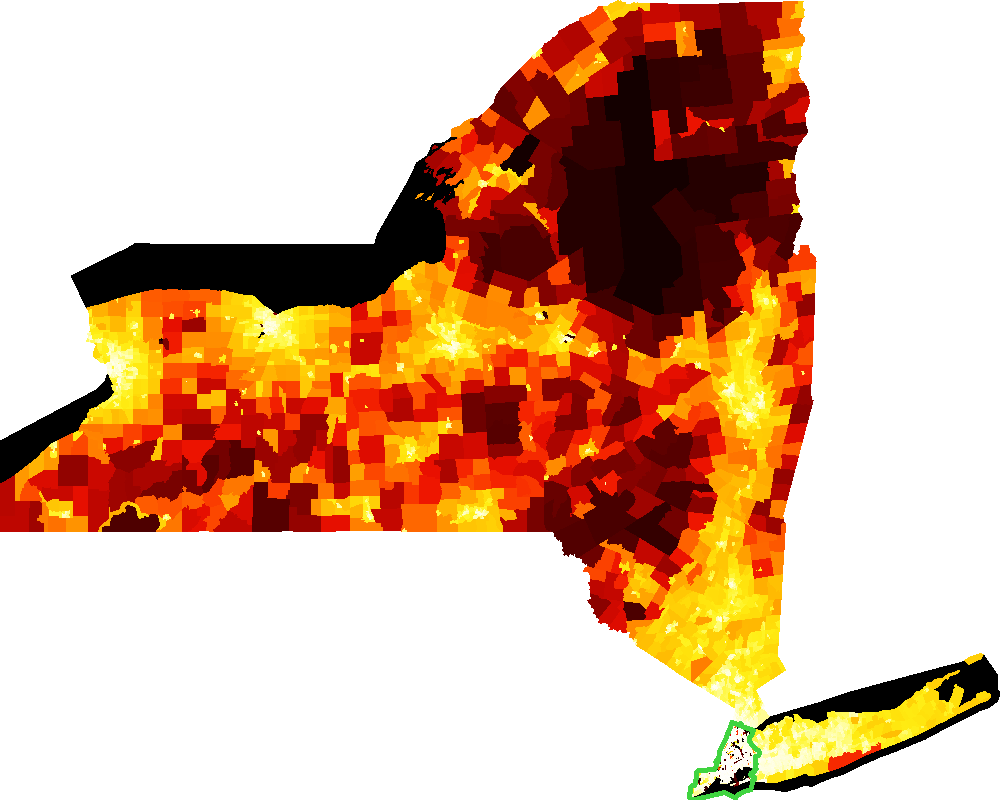

In [11]:
import datashader as ds
import colorcet as cc # check if any issues with colorcet...

pop_bounds = sp_geodf_tract_ny['geometry'].total_bounds
nyc_bounds = sp_geodf_place_nyc['geometry'].total_bounds

min_x = min(pop_bounds[0], nyc_bounds[0])
min_y = min(pop_bounds[1], nyc_bounds[1])
max_x = max(pop_bounds[2], nyc_bounds[2])
max_y = max(pop_bounds[3], nyc_bounds[3])


canvas = ds.Canvas(plot_width=1000, plot_height=800, x_range=(min_x, max_x), y_range=(min_y, max_y) )
population_aggregate = canvas.polygons(sp_geodf_tract_ny, geometry='geometry', agg=ds.mean('Population Density') )

# RGB colors 0->255 for each R, G, B
lime_green = (64, 212, 64)
pop_img = ds.transfer_functions.shade(population_aggregate, cmap=cc.fire)
nyc_img = ds.transfer_functions.shade(canvas.line(sp_geodf_place_nyc, geometry='geometry', agg=ds.any(), line_width=4), cmap=[lime_green]);

ds.tf.stack(pop_img, nyc_img)